In [1]:
# %load C60_jupyter_imports.py
%load_ext autoreload
%autoreload 2

import xarray as xr
import numpy as np
from dask.distributed import Client
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
import xesmf as xe
from scipy.stats import linregress
import os
import requests
import cftime
# Lets import our functions. There are no tests here. Stored separately so as to not make a mess.
# Make sure in right dir first

os.chdir('/g/data/xv83/np1383/src_CAFE60_eqpac_analysis_code/')

In [2]:
ls /g/data/xv83/dcfp/CAFE60v1/ocean_month.zarr.zip

/g/data/xv83/dcfp/CAFE60v1/ocean_month.zarr.zip*


In [3]:
bgc=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_bgc_month.zarr.zip')
bgc=bgc.rename({'xt_ocean':'lon','yt_ocean':'lat'})
bgc['lon']=bgc['lon']+360
eqpac=bgc.sel(lon=slice(120,290),lat=slice(-20,20))
#eqpac.time
eqpac

,Array,Chunk
Bytes,214.49 GiB,18.30 MiB
Shape,"(720, 96, 50, 98, 170)","(1, 96, 3, 98, 170)"
Count,24481 Tasks,12240 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,214.49 GiB,18.30 MiB
Shape,"(720, 96, 50, 98, 170)","(1, 96, 3, 98, 170)"
Count,24481 Tasks,12240 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [4]:
phys=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_month.zarr.zip')
phys=phys.rename({'xu_ocean':'lon','yu_ocean':'lat'})
phys=phys.rename({'xt_ocean':'lon_x','yt_ocean':'lat_x'})

phys['lon']=phys['lon']+360
phys['lon_x']=phys['lon_x']+360
phys['st_ocean']=phys['st_ocean']*-1
phys['sw_ocean']=phys['sw_ocean']*-1

In [5]:
zonal_current=phys.u.sel(lon=slice(120,290),lat=slice(-20,20))
v_current=phys.wt.sel(lon_x=slice(120,290),lat_x=slice(-20,20))

In [6]:
phys

,Array,Chunk
Bytes,1.36 TiB,118.65 MiB
Shape,"(720, 96, 50, 300, 360)","(1, 96, 3, 300, 360)"
Count,12241 Tasks,12240 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,1.36 TiB,118.65 MiB
Shape,"(720, 96, 50, 300, 360)","(1, 96, 3, 300, 360)"
Count,12241 Tasks,12240 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [7]:
# Set up the remote dask cluster. Can either use this version or a similar version above if building a LocalCluster.
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=2,memory="16GB")
client = Client(cluster)
cluster.scale(cores=12)
#cluster.adapt(minimum=2, maximum=16)
client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37087 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/37087/status,
Dashboard: /proxy/37087/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.128.156:39125,Workers: 0
Dashboard: /proxy/37087/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [11]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:35645")
client

<Client: 'tcp://127.0.0.1:35645' processes=8 threads=8, memory=22.46 GiB>

In [9]:
save_cutout=False
if save_cutout==True:
    dat=eqpac.sel(ensemble=25).sel(st_ocean=slice(0,2000))
    print(dat.nbytes/1e9)
    dat.to_zarr('../processed_data/cafe/eqpac/surface_bgc_ocean.zarr')

In [12]:
var='no3'
nitrate_ew_pac=eqpac[var].sel(ensemble=25,lat=0,method='nearest').sel(st_ocean=slice(0,1000))
nitrate_ew_pac['st_ocean']=nitrate_ew_pac['st_ocean']*-1
#nitrate_ew_pac.load()
#nitrate_ew_pac
nitrate_ew_pac80=nitrate_ew_pac.sel(time=slice(cftime.DatetimeJulian(1980, 1, 1),cftime.DatetimeJulian(1980, 12, 31))).mean(dim='time')
nitrate_ew_pac2020=nitrate_ew_pac.sel(time=slice(cftime.DatetimeJulian(2019, 1, 1),cftime.DatetimeJulian(2019, 12, 31))).mean(dim='time')
nitrate_ew_pac_tdiff=nitrate_ew_pac2020-nitrate_ew_pac80

#nitrate_ew_pac80.plot(vmin=0,vmax=70)
#nitrate_ew_pac2020.plot(vmin=0,vmax=70)

,Array,Chunk
Bytes,14.01 MiB,1.99 kiB
Shape,"(720, 30, 170)","(1, 3, 170)"
Count,43921 Tasks,7200 Chunks
Type,float32,numpy.ndarray


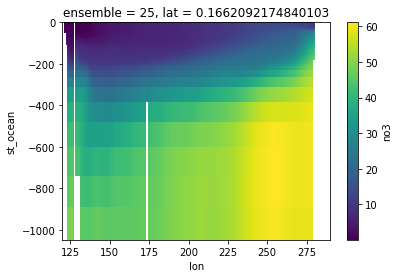

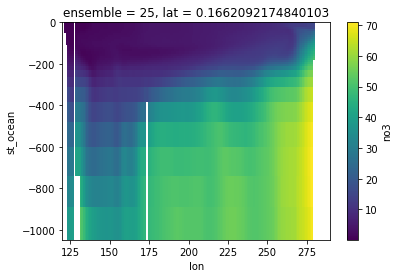

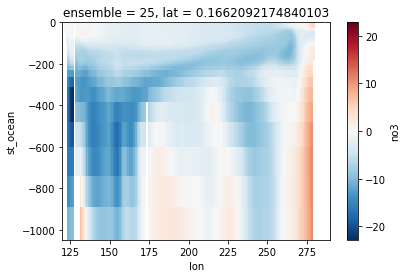

In [25]:
var='no3' #no3, fe
lat=0
ensemble=25

nitrate_ew_pac=eqpac[var].sel(ensemble=ensemble,lat=lat,method='nearest').sel(st_ocean=slice(0,1000))
nitrate_ew_pac['st_ocean']=nitrate_ew_pac['st_ocean']*-1
#nitrate_ew_pac.load()
#nitrate_ew_pac
nitrate_ew_pac80=nitrate_ew_pac.sel(time=slice(cftime.DatetimeJulian(1980, 1, 1),cftime.DatetimeJulian(1980, 12, 31))).mean(dim='time')
nitrate_ew_pac2020=nitrate_ew_pac.sel(time=slice(cftime.DatetimeJulian(2019, 1, 1),cftime.DatetimeJulian(2019, 12, 31))).mean(dim='time')
nitrate_ew_pac_tdiff=nitrate_ew_pac2020-nitrate_ew_pac80

nitrate_ew_pac80.plot()#(vmin=0,vmax=200)
plt.show()
nitrate_ew_pac2020.plot()#(vmin=0,vmax=200)
plt.show()
nitrate_ew_pac_tdiff.plot(cmap='bwr')#(vmin=-75,vmax=75,)
plt.show()

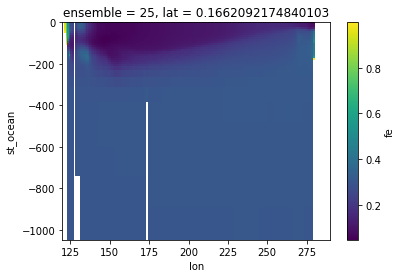

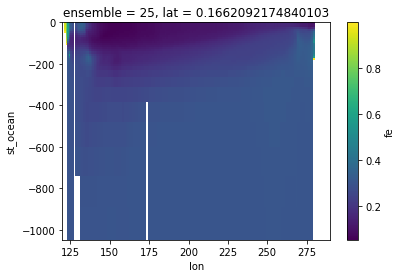

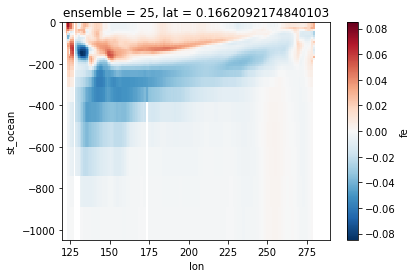

In [26]:
var='fe' #no3, fe
lat=0
ensemble=25

nitrate_ew_pac=eqpac[var].sel(ensemble=ensemble,lat=lat,method='nearest').sel(st_ocean=slice(0,1000))
nitrate_ew_pac['st_ocean']=nitrate_ew_pac['st_ocean']*-1
#nitrate_ew_pac.load()
#nitrate_ew_pac
nitrate_ew_pac80=nitrate_ew_pac.sel(time=slice(cftime.DatetimeJulian(1980, 1, 1),cftime.DatetimeJulian(1980, 12, 31))).mean(dim='time')
nitrate_ew_pac2020=nitrate_ew_pac.sel(time=slice(cftime.DatetimeJulian(2019, 1, 1),cftime.DatetimeJulian(2019, 12, 31))).mean(dim='time')
nitrate_ew_pac_tdiff=nitrate_ew_pac2020-nitrate_ew_pac80

nitrate_ew_pac80.plot()#(vmin=0,vmax=200)
plt.show()
nitrate_ew_pac2020.plot()#(vmin=0,vmax=200)
plt.show()
nitrate_ew_pac_tdiff.plot(cmap='bwr')#(vmin=-75,vmax=75,cmap='bwr')
plt.show()

,Array,Chunk
Bytes,217.95 GiB,18.60 MiB
Shape,"(720, 96, 50, 99, 171)","(1, 96, 3, 99, 171)"
Count,24481 Tasks,12240 Chunks
Type,float32,numpy.ndarray


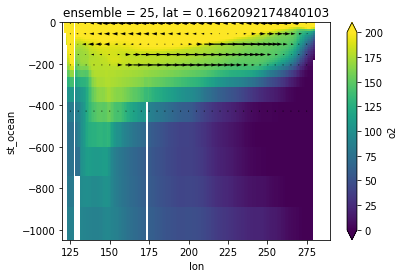

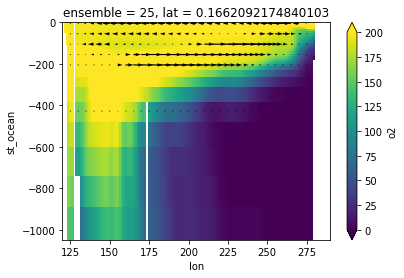

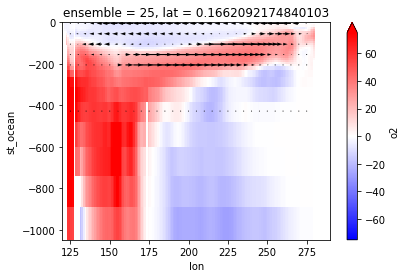

In [9]:
var='o2' #no3, fe
lat=0
ensemble=25

nitrate_ew_pac=eqpac[var].sel(ensemble=ensemble,lat=lat,method='nearest').sel(st_ocean=slice(0,1000))
nitrate_ew_pac['st_ocean']=nitrate_ew_pac['st_ocean']*-1
#nitrate_ew_pac.load()
#nitrate_ew_pac
nitrate_ew_pac80=nitrate_ew_pac.sel(time=slice(cftime.DatetimeJulian(1980, 1, 1),cftime.DatetimeJulian(1980, 12, 31))).mean(dim='time')
nitrate_ew_pac2020=nitrate_ew_pac.sel(time=slice(cftime.DatetimeJulian(2019, 1, 1),cftime.DatetimeJulian(2019, 12, 31))).mean(dim='time')
nitrate_ew_pac_tdiff=nitrate_ew_pac2020-nitrate_ew_pac80
dist=5
sk=(slice(None,None,dist))
sksk=(slice(None,None,dist),slice(None,None,dist))
zc=zonal_current.sel(ensemble=25,lat=0,method='nearest').sel(st_ocean=slice(0,-1000))
vc=v_current.sel(ensemble=25,lat_x=0,method='nearest').sel(sw_ocean=slice(0,-1000))

zc=zc.sel(time=slice(cftime.DatetimeJulian(1980, 1, 1),cftime.DatetimeJulian(1980, 12, 31))).mean(dim='time')
vc=vc.sel(time=slice(cftime.DatetimeJulian(1980, 1, 1),cftime.DatetimeJulian(1980, 12, 31))).mean(dim='time')
zc_fix=zc.sel(st_ocean=zc.st_ocean[:-1],lon=zc.lon[:-1])


nitrate_ew_pac80.plot(vmin=0,vmax=200)
plt.quiver(zc_fix.lon[sk],zc_fix.st_ocean[sk],zc_fix[sksk],vc[sksk],scale=12)
plt.show()
nitrate_ew_pac2020.plot(vmin=0,vmax=200)
plt.quiver(zc_fix.lon[sk],zc_fix.st_ocean[sk],zc_fix[sksk],vc[sksk],scale=12)
plt.show()
nitrate_ew_pac_tdiff.plot(vmin=-75,vmax=75,cmap='bwr')
plt.quiver(zc_fix.lon[sk],zc_fix.st_ocean[sk],zc_fix[sksk],vc[sksk],scale=12)
plt.show()

In [31]:
zc_fix

<xarray.DataArray 'u' (st_ocean: 29, lon: 170)>
dask.array<getitem, shape=(29, 170), dtype=float32, chunksize=(3, 170), chunktype=numpy.ndarray>
Coordinates:
    ensemble  int32 25
  * st_ocean  (st_ocean) float64 -5.0 -15.0 -25.0 -35.0 ... -536.7 -665.4 -812.8
  * lon       (lon) float64 120.0 121.0 122.0 123.0 ... 286.0 287.0 288.0 289.0
    lat       float64 -1e-09

In [51]:
cluster

KeyboardInterrupt: 

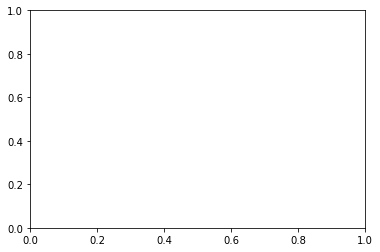

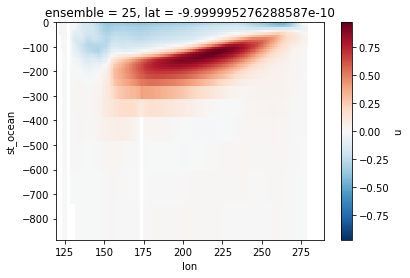

In [36]:
zc_fix.plot()

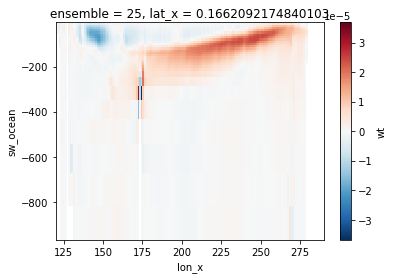

In [37]:
vc.plot()

In [11]:
plt.quiver?

Signature: plt.quiver(*args, data=None, **kw)
Docstring:
Plot a 2D field of arrows.

Call signature::

  quiver([X, Y], U, V, [C], **kw)

*X*, *Y* define the arrow locations, *U*, *V* define the arrow directions, and
*C* optionally sets the color.

**Arrow size**

The default settings auto-scales the length of the arrows to a reasonable size.
To change this behavior see the *scale* and *scale_units* parameters.

**Arrow shape**

The defaults give a slightly swept-back arrow; to make the head a
triangle, make *headaxislength* the same as *headlength*. To make the
arrow more pointed, reduce *headwidth* or increase *headlength* and
*headaxislength*. To make the head smaller relative to the shaft,
scale down all the head parameters. You will probably do best to leave
minshaft alone.

**Arrow outline**

*linewidths* and *edgecolors* can be used to customize the arrow
outlines.

Parameters
----------
X, Y : 1D or 2D array-like, optional
    The x and y coordinates of the arrow locations.

  

In [26]:
zc.plot.quiver(x=lat,y=time)

In [34]:
zc

<xarray.DataArray 'u' (st_ocean: 30, lon: 171)>
dask.array<mean_agg-aggregate, shape=(30, 171), dtype=float32, chunksize=(3, 171), chunktype=numpy.ndarray>
Coordinates:
    ensemble  int32 25
  * st_ocean  (st_ocean) float64 -5.0 -15.0 -25.0 -35.0 ... -665.4 -812.8 -969.1
  * lon       (lon) float64 120.0 121.0 122.0 123.0 ... 287.0 288.0 289.0 290.0
    lat       float64 -1e-09

In [ ]:
plt.quiver([zc.lon,zc.st_ocean],zc,0)

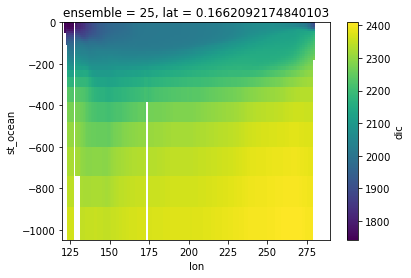

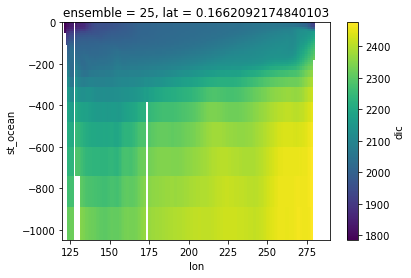

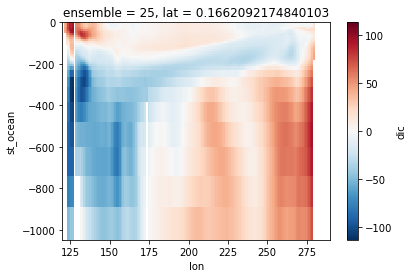

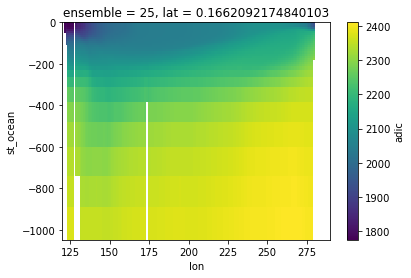

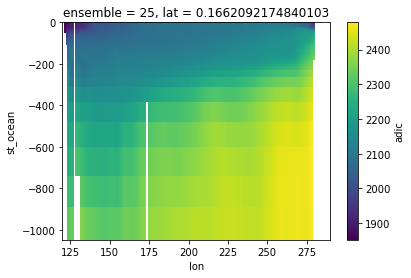

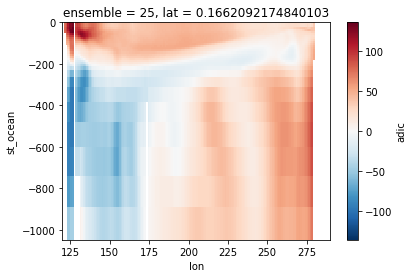

In [19]:
varx=['dic','adic'] #no3, fe
for i,var in enumerate(varx):
    lat=0
    ensemble=25

    dic_ew_pac=eqpac[var].sel(ensemble=ensemble,lat=lat,method='nearest').sel(st_ocean=slice(0,1000))
    dic_ew_pac['st_ocean']=dic_ew_pac['st_ocean']*-1

    dic_ew_pac80=dic_ew_pac.sel(time=slice(cftime.DatetimeJulian(1970, 1, 1),cftime.DatetimeJulian(1990, 12, 31))).mean(dim='time')
    dic_ew_pac2020=dic_ew_pac.sel(time=slice(cftime.DatetimeJulian(2000, 1, 1),cftime.DatetimeJulian(2019, 12, 31))).mean(dim='time')
    dic_ew_pac_tdiff=dic_ew_pac2020-dic_ew_pac80

    dic_ew_pac80.plot()#(vmin=0,vmax=150)
    plt.show()
    dic_ew_pac2020.plot()#(vmin=0,vmax=150)
    plt.show()
    dic_ew_pac_tdiff.plot()#(vmin=-100,vmax=100)
    plt.quiver(zc.lon,zc.st_ocean,zc)
    plt.show()
    
    if i==0:
        dic80=dic_ew_pac80
        dic20=dic_ew_pac2020
    elif i==1:
        adic80=dic_ew_pac80
        adic20=dic_ew_pac2020

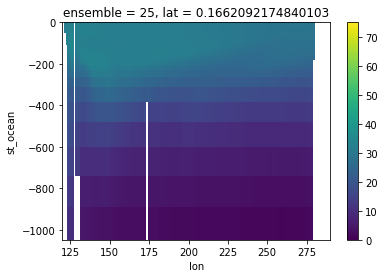

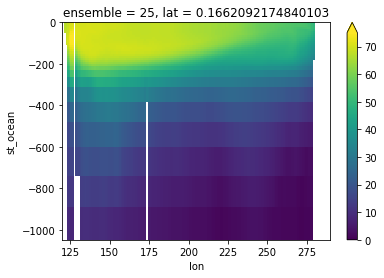

In [27]:
(adic80-dic80).plot(vmin=0,vmax=75)
plt.show()
(adic20-dic20).plot(vmin=0,vmax=75)
plt.show()


In [29]:
# Try do the Latitudinal cross section, but need to fix the chunking maybe.
nitrate_ens_pac=eqpac.no3.sel(ensemble=25,lon=260,method='nearest').sel(st_ocean=slice(0,1000))
nitrate_ens_pac['st_ocean']=nitrate_ens_pac['st_ocean']*-1
#nitrate_ens_pac.load()

In [30]:
nitrate_ens_pac80=nitrate_ens_pac.sel(time=slice(cftime.DatetimeJulian(1980, 1, 1),cftime.DatetimeJulian(1980, 12, 31))).mean(dim='time').chunk({'lat':1})

In [31]:
nitrate_ens_pac80

<xarray.DataArray 'no3' (st_ocean: 30, lat: 98)>
dask.array<rechunk-merge, shape=(30, 98), dtype=float32, chunksize=(3, 1), chunktype=numpy.ndarray>
Coordinates:
    ensemble  int32 25
  * st_ocean  (st_ocean) float64 -5.0 -15.0 -25.0 -35.0 ... -665.4 -812.8 -969.1
    lon       float64 260.5
  * lat       (lat) float64 -19.36 -18.59 -17.85 -17.15 ... 17.85 18.59 19.36

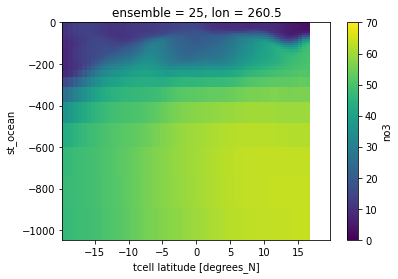

In [32]:
nitrate_ens_pac80.plot(vmin=0,vmax=70)

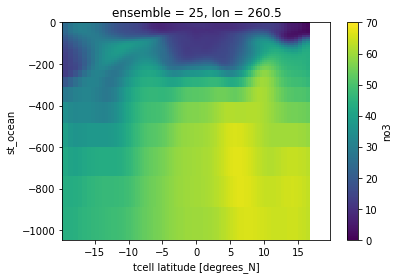

In [34]:
nitrate_ens_pac2020=nitrate_ens_pac.sel(time=slice(cftime.DatetimeJulian(2019, 1, 1),cftime.DatetimeJulian(2019, 12, 31))).mean(dim='time')
nitrate_ens_pac2020.plot(vmin=0,vmax=70)

In [39]:
# Try do the Latitudinal cross section, but need to fix the chunking maybe.
nitrate_wns_pac=eqpac.no3.sel(ensemble=25,lon=160,method='nearest').sel(st_ocean=slice(0,1000))
nitrate_wns_pac['st_ocean']=nitrate_wns_pac['st_ocean']*-1
#nitrate_ens_pac.load()
nitrate_wns_pac80=nitrate_wns_pac.sel(time=slice(cftime.DatetimeJulian(1980, 1, 1),cftime.DatetimeJulian(1980, 12, 31))).mean(dim='time')
nitrate_wns_pac2020=nitrate_wns_pac.sel(time=slice(cftime.DatetimeJulian(2019, 1, 1),cftime.DatetimeJulian(2019, 12, 31))).mean(dim='time')

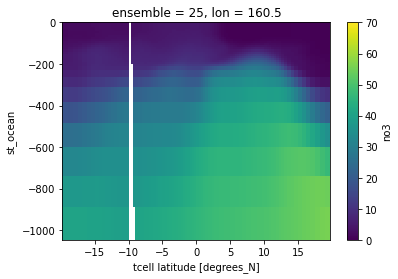

In [40]:
nitrate_wns_pac80.plot(vmin=0,vmax=70)

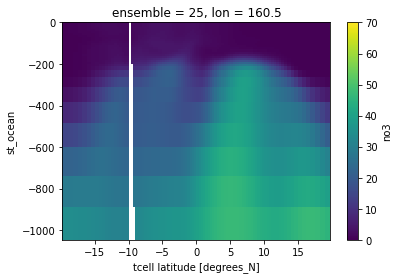

In [42]:
nitrate_wns_pac2020.plot(vmin=0,vmax=70)